# DC profile over 2 cylinders: PGI without Petrophysical information, inclusion of geological constraints

### This notebook reproduces the DC example from Astic & Oldenburg 2019.

A DC resistivity profile is acquired over two cylinders. We illustrate the performance of this framework when no physical property mean values are available, and compared it to the result with full petrophysical information. We highlight then how geological information from borehole logs can be incorporated into this framework. 

For that purpose, we first start by running a Tikhonov inversion and a PGI with full petrophysical information to set benchmarks. We then run a PGI without providing any information about the physical property mean values nor the proportions. We finally run another PGI, still without means information, but with added geological information included through the use of local proportions. All inversions share the same starting weighting of the geophysical objective function terms.

In [2]:
# Import
from SimPEG import (
    Mesh,  Maps,  Utils, DataMisfit,  Regularization,
    Optimization, InvProblem,  Directives,  Inversion
)
from SimPEG.EM.Static import DC, Utils as DCUtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pymatsolver import PardisoSolver
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
import seaborn
seaborn.set()

from PGI_DC_example_Utils import plot_pseudoSection, getCylinderPoints

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

%matplotlib inline

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]


# Setup

In [2]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = Mesh.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(100.)
ln_sigc = -np.log(50.)
ln_sigr = -np.log(250.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

mtrue = Utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = Utils.meshutils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


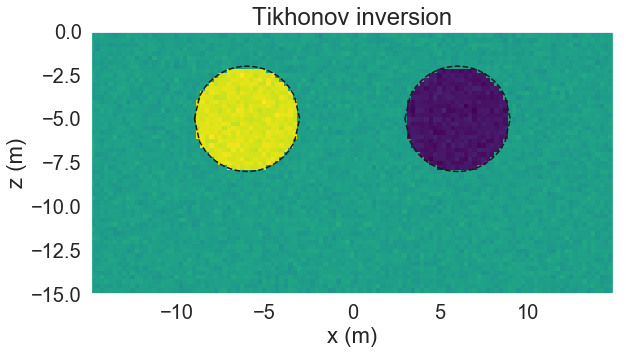

In [3]:
# Plot the ground-truth model
clim = [mtrue.min(), mtrue.max()]
cyl0 = getCylinderPoints(x0, z0, r0)
cyl1 = getCylinderPoints(x1, z1, r1)
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
plt.show()
#fig.savefig('DC2p5D_GroundTruth_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_GroundTruth_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


In [4]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.gen_DCIPsurvey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.gen_DCIPsurvey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = DC.Survey_ky(survey1.srcList + survey2.srcList)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = Maps.ExpMap(mesh)
mapactive = Maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(100)
)
mapping = expmap * mapactive
problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
problem.pair(survey)
problem.Solver = PardisoSolver

std = 0.02
survey.dpred(mtrue[actcore])
survey.makeSyntheticData(mtrue[actcore], std=std, force=True)
survey.eps = 1e-4#np.linalg.norm(Utils.mkvc(survey.dobs), 2)*(1e-5)

m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)

expmap = Maps.ExpMap(mesh)
mapactive = Maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=np.unique(m0)
)
mapping = expmap * mapactive
problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
survey.unpair()
problem.pair(survey)
problem.Solver = PardisoSolver


Compute fields
Compute fields
SimPEG.Survey assigned new std of 2.00%


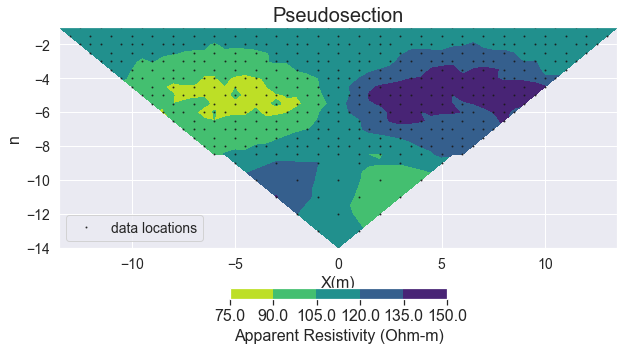

In [5]:
# Plot the pseudosection
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax,midx, midz,grid_x,grid_z,rho=plot_pseudoSection(survey,ax=ax,data_type="appResistivity",scale='linear',clim=[75.,150],
                          data_location=True,sameratio=False, pcolorOpts={'cmap':'viridis_r',
                                                                          'levels':[75,90,105,120,135,150]})
ax.set_title("Pseudosection",fontsize=20)
plt.show()
#fig.savefig('DC2p5D_Data_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Data_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)

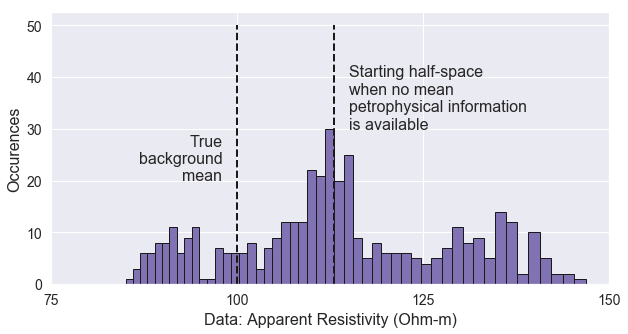

In [6]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,1,figsize=(10,5))
hist, edges = np.histogram(-np.log(((DCUtils.apparent_resistivity(survey)))),bins=50, density=False)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
ax.grid(True,which='both')
ax.grid(True,which="majorminor",ls="-")

ax.set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylabel('Occurences',fontsize=16)
ax.set_xticks(np.r_[75,100,125,150])

plt.show()
#fig.savefig('DC2p5D_Hist_Data_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_Data_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)

In [7]:
# Generate the GMM petrophysical distribution
n = 3
clf = Utils.WeightedGaussianMixture(
    n_components=n,mesh=meshCore,  covariance_type='full', reg_covar=1e-3, 
    means_init= np.r_[-np.log(100.), -np.log(50.), -np.log(250.)][:,np.newaxis]
)
clf.fit(mtrue[actcore].reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)
clf.means_ = np.r_[-np.log(100.), -np.log(50.), -np.log(250.)][:,np.newaxis]
clf.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])
clf.precisions_cholesky_ = Utils.petroutils._compute_precision_cholesky(clf.covariances_, clf.covariance_type)
Utils.petroutils.computePrecision(clf)

(0.0, 12.0)

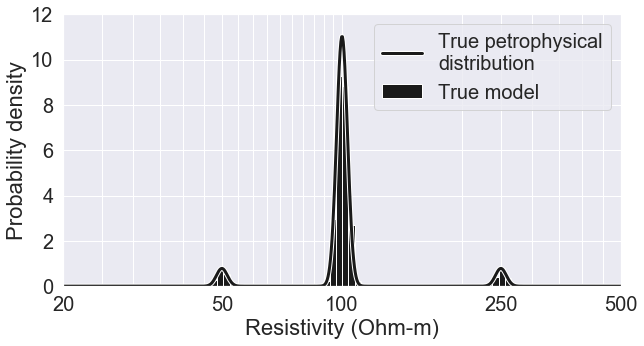

In [8]:
# Plot the histogram of the true model with the petrophysical distribution
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

ax.plot(testXplot, np.exp(clf.score_samples(-np.log(testXplot))),linewidth=3,label='True petrophysical\ndistribution',c='k',
       path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='major')
ax.grid(True,which="majorminor",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mtrue[actcore],bins=50, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="w", align="edge",label='True model',color='k')
ax.legend(loc=0,fontsize=20)
ax.set_ylim([0.,12.])
#fig.savefig('DC2p5D_Hist_TrueDist_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_TrueDist_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


# Tikhonov Inversion

In [9]:
#####################
# Tikhonov Inversion#
#####################

# Weighting
betavalue = 100.
alpha_x = 100.
alpha_y = 100.

# Initial model: best fitting half-space
m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)

# Data Misfit object
dmis = DataMisfit.l2_DataMisfit(survey)


regT = Regularization.Simple(mesh, indActive=actcore)
regT.alpha_s = 1/csx**2.
regT.alpha_x = alpha_x
regT.alpha_y = alpha_y
regT.alpha_z = alpha_y

# Optimization object
opt = Optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = InvProblem.BaseInvProblem(dmis,  regT,  opt)
invProb.beta = betavalue

# Inversion directives
Target = Directives.TargetMisfit()
betaSched = Directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = Directives.UpdateSensitivityWeights(threshold=1e-3,everyIter=False)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,  directiveList=[updateSensW, 
                                                       Target,
                                                       betaSched,
                                                       update_Jacobi,
                                                       ])
# Run
mnormal = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Compute fields
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
Compute fields
   0  1.00e+02  1.56e+04  0.00e+00  1.56e+04    6.91e+02      0              
Compute fields
   1  5.00e+01  2.33e+03  2.85e+01  3.76e+03    4.24e+02      0              
Compute fields
   2  2.50e+01  1.19e+03  4.43e+01  2.30e+03    3.10e+02      0   Skip BFGS  
Compute fields
   3  1.25e+01  6.25e+02  6.02e+01  1.38e+03    2.08e+02      0   Skip BFGS  
Compute fields
   4  6.25e+00  3.57e+02  7.51e+01  8.27e+02    1.30e+02      0   Skip BFGS  
Compute fields
   5  3.12e+00 

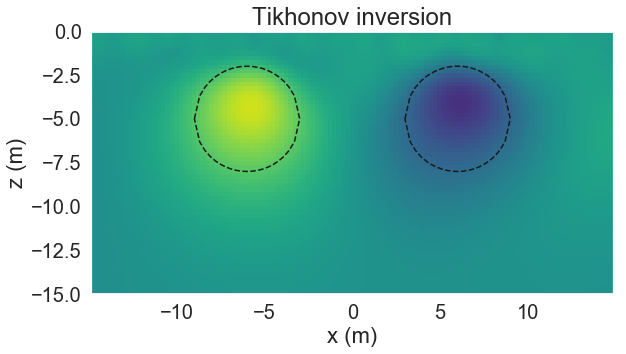

In [10]:
# Plot the recovered model
clim = [mtrue.min(), mtrue.max()]
cyl0 = getCylinderPoints(x0, z0, r0)
cyl1 = getCylinderPoints(x1, z1, r1)
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mnormal, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
#fig.savefig('DC2p5D_Tikhonov_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Tikhonov_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


(0.0, 12.0)

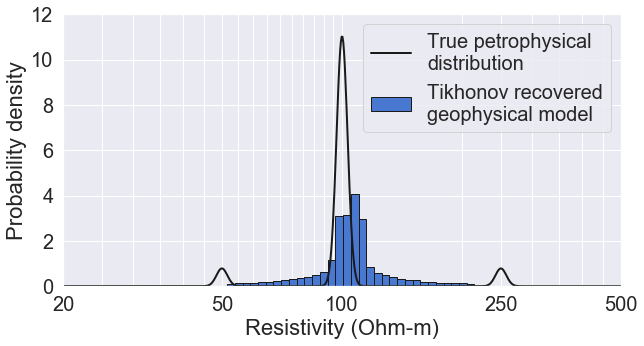

In [11]:
# Plot the histogram of the Tikhonov recovered model

fig, ax = plt.subplots(1,1,figsize=(10,5))

testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

ax.plot(testXplot, np.exp(clf.score_samples(-np.log(testXplot))),
        linewidth=2,label='True petrophysical\ndistribution',c='k'
)
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="majorminor",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mnormal,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), 
       ec="k", align="edge",label='Tikhonov recovered\ngeophysical model',color='#4878CF'
)
ax.legend(loc=0,fontsize=20)
ax.set_ylim([0.,12.])
#fig.savefig('DC2p5D_Hist_tikhonov_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_tikhonov_lowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


(0.0, 1.0, 0.0, 1.0)

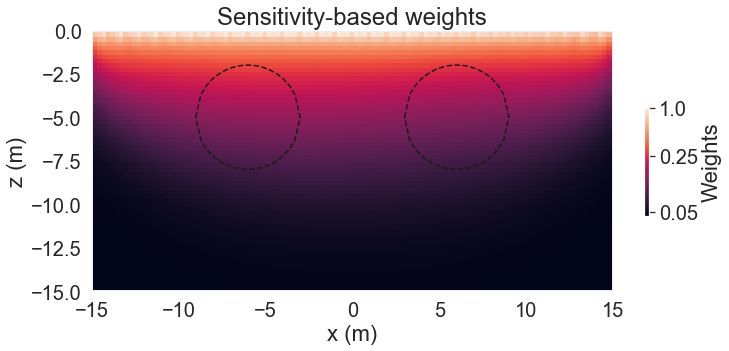

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sensweights = sp.csr_matrix.diagonal(regT.objfcts[0].W)
dat = meshCore.plotImage(np.log(sensweights), ax=ax)
ax.set_title('Sensitivity-based weights',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = plt.colorbar(dat[0], ax=cbar_ax)
cb.set_label('Weights',fontsize=22)
cb.set_ticks([np.log(0.05),np.log(0.25),np.log(1)], )
cb.set_ticklabels([0.05,0.25,1.],)
cb.ax.tick_params(labelsize=20)
cbar_ax.axis('off')
#fig.savefig('DC2p5D_SensW_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_SensW_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


# PGI with full petrophysical information

In [13]:
#########################################
# Petrophysically constrained inversion #
#########################################

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = Maps.ExpMap(mesh)
mapactive = Maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(100.)
)
mapping = expmap * mapactive
problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
survey.unpair()
problem.pair(survey)
problem.Solver = PardisoSolver

# Set the initial model to the true background mean
m0 = -np.log(100.) * np.ones(mapping.nP)

# fit a Gaussian Mixture Model with n components
# on the true model to simulate the laboratory
# petrophysical measurements
dmis = DataMisfit.l2_DataMisfit(survey)

n = 3
clf = Utils.WeightedGaussianMixture(
    n_components=n, mesh=meshCore,  covariance_type='full', reg_covar=1e-3, 
    means_init= np.r_[-np.log(100.), -np.log(50.), -np.log(250.)][:,np.newaxis]
)
clf.fit(mtrue[actcore].reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)
clf.means_ = np.r_[-np.log(100.), -np.log(50.), -np.log(250.)][:,np.newaxis]
clf.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])
clf.precisions_cholesky_ = Utils.petroutils._compute_precision_cholesky(clf.covariances_, clf.covariance_type)
Utils.petroutils.computePrecision(clf)

# Create the regularization with GMM information
idenMap = Maps.IdentityMap(nP=m0.shape[0])
wires = Maps.Wires(('m', m0.shape[0]))
reg_mean = Regularization.SimplePetroRegularization(
    GMmref=clf,  mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actcore
)

# Weighting
reg_mean.alpha_s = 0.016
reg_mean.alpha_x = alpha_x
reg_mean.alpha_y = alpha_y
reg_mean.mrefInSmooth = False
reg_mean.approx_gradient = True


# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=20, lower=-10, upper=10,
    maxIterLS=20, maxIterCG=100, tolCG=1e-5)
opt.remember('xc')

# Set the inverse problem
invProb = InvProblem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5.,
    rateWarming=1., tolerance=0.05,
    progress=0.1
)
targets = Directives.PetroTargetMisfit(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = Directives.AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
petrodir = Directives.GaussianMixtureUpdateModel(
    update_covariances=True,
    kappa = 1e8,
    nu = 1e8,
    alphadir = 1e8)
updateSensW = Directives.UpdateSensitivityWeights(threshold=1e-3, everyIter=False)
update_Jacobi = Directives.UpdatePreconditioner()
invProb.beta = betavalue
inv = Inversion.BaseInversion(invProb,
                              directiveList=[
                                             updateSensW,
                                             petrodir,
                                             targets, betaIt,
                                             MrefInSmooth,
                                             update_Jacobi,
                                             ])

# Run!
mcluster = inv.run(m0)


                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Compute fields
Compute fields
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
Compute fields
   0  1.00e+02  7.07e+03  0.00e+00  7.07e+03    5.58e+02      0              
Compute fields
Compute fields
DM:  [1623.58970143] [False] ; CL:  37982.626715532024 False ; DP:  True ; All: False
progress [1623.58970143] >< [6358.62537112]
mref changes in  0  places
   1  1.00e+02  1.62e+03  1.51e+01  3.13e+03    6.62e+01      0              
Compute fields
Compute fields
DM:  [1614.57984382] [False] ; CL:  38137.44376903718 False ; DP:  True ; All: False
progress [1614.57984382] >< [1461.23073129]
update beta for c

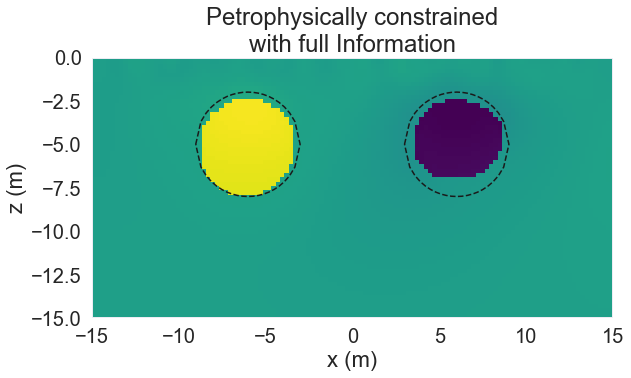

In [14]:
# Plot the PGI recovered model
clim = [mtrue.min(), mtrue.max()]
cyl0 = getCylinderPoints(x0, z0, r0)
cyl1 = getCylinderPoints(x1, z1, r1)
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mcluster, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
plt.show()

#fig.savefig('DC2p5D_WithMean_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_WithMean_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


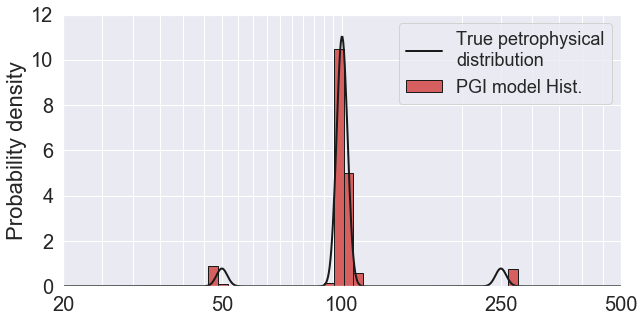

In [15]:
# plot the histogram of the PGI recovered model
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(clf.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="majorminor",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mcluster,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

#fig.savefig('DC2p5D_Hist_WithMean_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_WithMean_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


# PGI without mean information

In [16]:
#########################################
# Petrophysically constrained inversion #
#########################################

# Initial model: best-fitting half-space
m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = Maps.ExpMap(mesh)
mapactive = Maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=np.unique(m0)
)

mapping = expmap * mapactive
problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
survey.unpair()
problem.pair(survey)
problem.Solver = PardisoSolver

# fit a Gaussian Mixture Model with n components
# on the true model to simulate the laboratory
# petrophysical measurements
dmis = DataMisfit.l2_DataMisfit(survey)
n = 3
clfnomean = Utils.WeightedGaussianMixture(
    n_components=n,mesh=meshCore,  covariance_type='full', reg_covar=1e-3, 
    n_init=20,
)
clfnomean.fit(mtrue[actcore].reshape(-1, 1))
Utils.order_clusters_GM_weight(clfnomean)
m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)
clfnomean.means_ = np.r_[np.unique(m0), -np.log(75.), -np.log(125.)][:,np.newaxis]
clfnomean.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])
clfnomean.precisions_cholesky_ = Utils.petroutils._compute_precision_cholesky(clfnomean.covariances_, clfnomean.covariance_type)
Utils.petroutils.computePrecision(clfnomean)

# Create the regularization with GMM information
idenMap = Maps.IdentityMap(nP=m0.shape[0])
wires = Maps.Wires(('m', m0.shape[0]))
reg_nomean = Regularization.SimplePetroRegularization(
    GMmref=clfnomean,  mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actcore
)
reg_nomean.mrefInSmooth = False
reg_nomean.approx_gradient = True
reg_nomean.alpha_s = 0.016
reg_nomean.alpha_x = alpha_x
reg_nomean.alpha_y = alpha_y

# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=20, lower=-10, upper=10,
    maxIterLS=20, maxIterCG=100, tolCG=1e-5)
opt.remember('xc')

# Set the inverse problem
invProb = InvProblem.BaseInvProblem(dmis,  reg_nomean,  opt)
invProb.beta = betavalue

# Inversion directives
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5.,
    rateWarming=1., tolerance=1.,
    progress=0.1
)
targets = Directives.PetroTargetMisfit(
    chifact = 1.,
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
petrodir = Directives.GaussianMixtureUpdateModel(
    update_covariances=True,
    kappa=0.,
    nu=1e8,
    alphadir=0.)
updateSensW = Directives.UpdateSensitivityWeights(threshold=1e-3, everyIter=False)
update_Jacobi = Directives.UpdatePreconditioner()
MrefInSmooth = Directives.AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)

inv = Inversion.BaseInversion(invProb,
                              directiveList=[
                                              updateSensW,
                                             petrodir,
                                             targets, betaIt,
                                             MrefInSmooth,
                                             update_Jacobi,
                                             ])

# Run!
mcluster_nomean = inv.run(m0)



                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Compute fields
Compute fields
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
Compute fields
   0  1.00e+02  1.56e+04  0.00e+00  1.56e+04    6.91e+02      0              
Compute fields
Compute fields
DM:  [2331.05533297] [False] ; CL:  8355.230567866609 False ; DP:  True ; All: False
progress [2331.05533297] >< [14049.37548949]
mref changes in  2273  places
   1  1.00e+02  2.33e+03  6.74e+00  3.01e+03    4.59e+02      0              
Compute fields
Compute fields
DM:  [1187.98424977] [False] ; CL:  8042.572087428226 False ; DP:  True ; All: False
progress [1187.98424977] >< [2097.94979968]
mref changes i

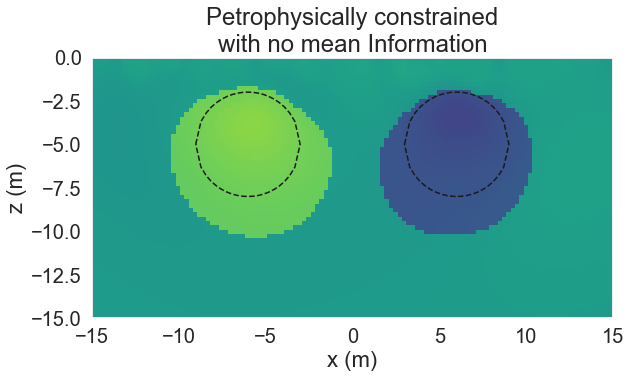

In [17]:
# Plot the PGI recovered model without mean information
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mcluster_nomean, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Petrophysically constrained\nwith no mean Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
#fig.savefig('DC2p5D_WithNoMean_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_WithNoMean_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


(0.0, 12.0)

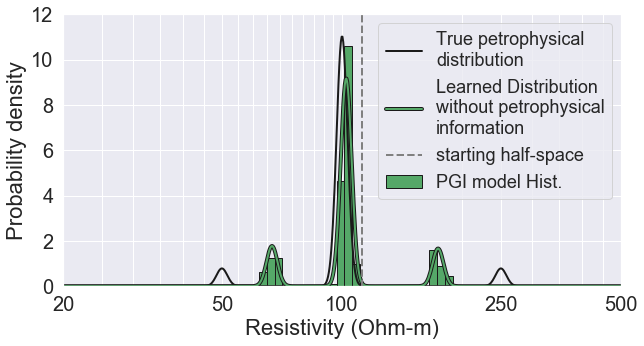

In [18]:
# Plot the recovered model histogram and learned petrophysical distribution from PGI without mean information
m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(clf.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.plot(testXplot, np.exp(reg_nomean.objfcts[0].GMmodel.score_samples(-np.log(testXplot))),
        linewidth=2,label='Learned Distribution\nwithout petrophysical\ninformation',c='g',
       path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="majorminor",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mcluster_nomean,bins=25, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='#55a868')
ax.plot((1./np.exp(np.unique(m0)))*np.ones(2),[-.5,12],linestyle='dashed',linewidth=2.,c='gray',label='starting half-space')
ax.legend(loc=1,fontsize=18)
ax.set_ylim([0.,12.])

#fig.savefig('DC2p5D_Hist_WithNoMean_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_WithNoMean_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)

# PGI with boreholes

In [19]:
# initialize the GMM with the one learned from PGI without mean information
clfborehole = copy.deepcopy(reg_nomean.objfcts[0].GMmodel)
Utils.order_clusters_GM_weight(clfborehole)

In [32]:
# Create the boreholes
# find the boreholes indexes
indborehole0 = mesh.gridCC[actcore,0] == x0
indborehole1 = mesh.gridCC[actcore,0] == x1
indborehole2 = mesh.gridCC[actcore,0] == np.mean((x0,x1))
indbasement = mesh.gridCC[actcore,1] <-8.
borehole_lithology0 = clfborehole.predict((mtrue[actcore][indborehole0]).reshape(-1,1))
borehole_lithology1 = clfborehole.predict((mtrue[actcore][indborehole1]).reshape(-1,1))
borehole_lithology2 = clfborehole.predict((mtrue[actcore][indborehole2]).reshape(-1,1))
indborehole = [indborehole0,indborehole1]
borehole_lithology = [borehole_lithology0, borehole_lithology1,borehole_lithology2]
m0borehole = np.zeros_like(mtrue[actcore])*np.nan
for bidx, lth in zip(indborehole, borehole_lithology):
            m0borehole[bidx] = Utils.mkvc(clfborehole.means_[lth])

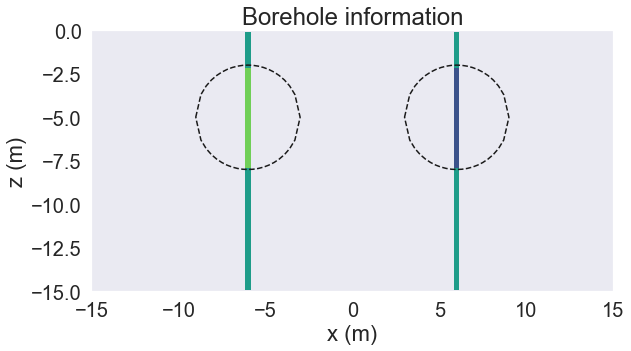

In [33]:
# Visualize the boreholes
fig, ax = plt.subplots(1,1,figsize=(10,5))
clim = [mtrue.min(), mtrue.max()]
dat = meshCore.plotImage(m0borehole, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})

ax.set_title('Borehole information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
cyl0 = getCylinderPoints(x0, z0, r0)
cyl1 = getCylinderPoints(x1, z1, r1)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
#fig.savefig('DC2p5D_Boreholes_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Boreholes_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


In [34]:
# Create the proprotions profiles
z = meshCore.vectorCCy
pi0 = np.count_nonzero(np.c_[borehole_lithology].T==0,axis=1) 
pi1 = np.count_nonzero(np.c_[borehole_lithology].T==1,axis=1) 
pi2 = np.count_nonzero(np.c_[borehole_lithology].T==2,axis=1)

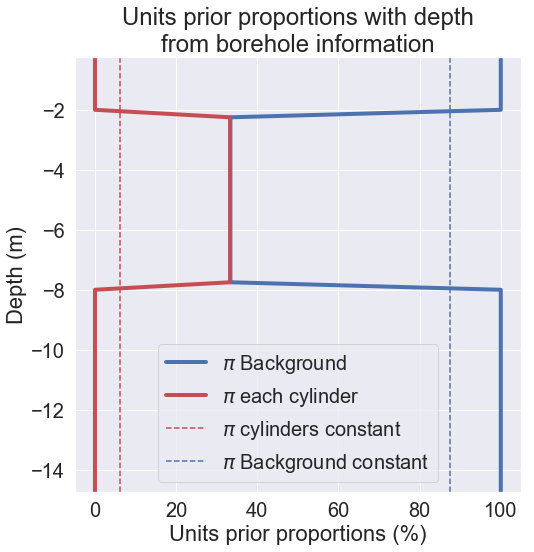

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
testZplot = np.linspace(z.min(),z.max(),1000)[:,np.newaxis]
plt.gca().plot(pi0/3.,z,'b',linewidth=4.,linestyle='-',label='$\pi$ Background')
ax.plot(pi2/3.,z,
        linewidth=4,label='$\pi$ each cylinder',c='r',)
ax.plot(np.ones_like(z)*clf.weights_[1],z,linestyle='--',c='r',label='$\pi$ cylinders constant')
ax.plot(np.ones_like(z)*clf.weights_[0],z,linestyle='--',c='b',label='$\pi$ Background constant')
ax.set_ylim([z.min(),z.max()])
ax.tick_params(labelsize=20)
ax.set_xlabel('Units prior proportions (%)',fontsize=22)
ax.set_ylabel('Depth (m)',fontsize=22)
ax.set_xticks(0.01*np.r_[0,20,40,60,80,100])
ax.set_xticklabels(np.r_[0,20,40,60,80,100])
ax.set_title('Units prior proportions with depth\nfrom borehole information',fontsize=24)
ax.legend(fontsize=20)
#fig.savefig('DC2p5D_Proportions_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Proportions_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)


In [36]:
# Build the local proportions over the mesh
weights_mesh = np.ones((meshCore.nC,3))*1e-16
for zz in z:
    idz = meshCore.gridCC[:,1] == zz
    weights_mesh[idz,0] = pi0[zz==z]/3.+1e-16
    weights_mesh[idz,1] = pi1[zz==z]/3.+1e-16
    weights_mesh[idz,2] = pi2[zz==z]/3.+1e-16

# Add the boreholes
for bidx, lth in zip(indborehole, borehole_lithology):
    test = np.ones((np.count_nonzero(bidx),3))*(1e-16)
    test[np.arange(len(test)),np.array(lth,dtype='int64')] = 1
    weights_mesh[bidx] = test

In [37]:
#########################################
# Petrophysically constrained inversion #
#########################################

# initial model: half-space + boreholes lithology
# with the values learned from PGI without mean information
m0 = Utils.mkvc(reg_nomean.objfcts[0].GMmodel.means_[weights_mesh.argmax(axis=1)])

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = Maps.ExpMap(mesh)
mapactive = Maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=reg_nomean.objfcts[0].GMmodel.means_[0]
)
mapping = expmap * mapactive
problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
survey.unpair()
problem.pair(survey)
problem.Solver = PardisoSolver
dmis = DataMisfit.l2_DataMisfit(survey)

# Create the regularization with GMM information
idenMap = Maps.IdentityMap(nP=m0.shape[0])
wires = Maps.Wires(('m', m0.shape[0]))
reg_nomean_geo = Regularization.SimplePetroRegularization(
    GMmref=clfborehole,  mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actcore
)
#Weighting
reg_nomean_geo.alpha_s = 0.016
reg_nomean_geo.alpha_x = alpha_x
reg_nomean_geo.alpha_y = alpha_y
reg_nomean_geo.mrefInSmooth = False
reg_nomean_geo.approx_gradient = True

# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=20, lower=-10, upper=10,
    maxIterLS=20, maxIterCG=50, tolCG=1e-4
)
opt.remember('xc')

# Set the inverse problem
invProb = InvProblem.BaseInvProblem(dmis,  reg_nomean_geo,  opt)

# Inversion directives
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5.,
    rateWarming=1., tolerance=1.,
    progress=0.1
)
targets = Directives.PetroTargetMisfit(
    chifact = 1.,
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = Directives.AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
petrodir = Directives.GaussianMixtureUpdateModel(
    update_covariances=True,
    kappa=0,
    nu=1e8,
    alphadir=0)

update_Jacobi = Directives.UpdatePreconditioner()
updateSensW = Directives.UpdateSensitivityWeights(threshold=1e-3,everyIter=False)
#Include the local proportions 
borehole = Directives.BoreholeLithologyConstraintsEllipsoidMixture(
    borehole_weights=weights_mesh
)
invProb.beta = betavalue
inv = Inversion.BaseInversion(invProb,
                              directiveList=[updateSensW,
                                             petrodir,
                                             borehole,
                                             targets, betaIt,
                                             MrefInSmooth,
                                             update_Jacobi,
                                             ])

# Run
mcluster_nomean_borehole = inv.run(m0)


                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Compute fields
Compute fields
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
Compute fields
   0  1.00e+02  8.30e+03  2.87e+01  1.12e+04    5.92e+02      0              
Compute fields
Compute fields
DM:  [1747.16874204] [False] ; CL:  9982.2579933261 False ; DP:  True ; All: False
progress [1747.16874204] >< [7472.25972921]
mref changes in  1867  places
   1  1.00e+02  1.75e+03  5.47e+00  2.29e+03    2.78e+02      0              
Compute fields
Compute fields
DM:  [966.21053199] [False] ; CL:  9117.009694406588 False ; DP:  True ; All: False
progress [966.21053199] >< [1572.45186784]
mref changes in  45

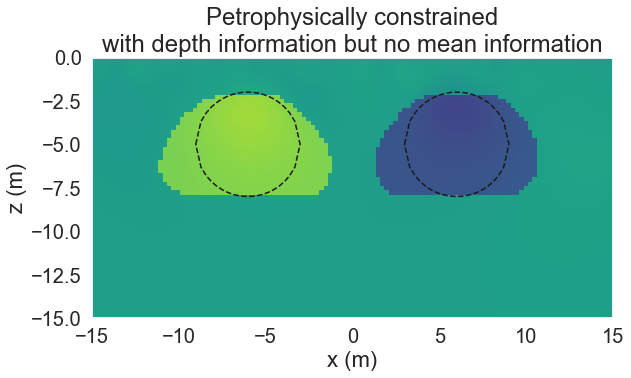

In [38]:
# Plot the recovered model for PGI without mean info. but with geological constraints
fig, ax = plt.subplots(1,1,figsize=(10,5))
clim = [mtrue.min(), mtrue.max()]
dat = meshCore.plotImage(mcluster_nomean_borehole, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})

ax.set_title('Petrophysically constrained\nwith depth information but no mean information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
cyl0 = getCylinderPoints(x0, z0, r0)
cyl1 = getCylinderPoints(x1, z1, r1)
ax.plot(cyl0[:, 0], cyl0[:, 1], 'k--')
ax.plot(cyl1[:, 0], cyl1[:, 1], 'k--')
fig.subplots_adjust(right=0.85)
plt.show()

#fig.savefig('DC2p5D_WithBoreholes_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_WithBoreholes_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)

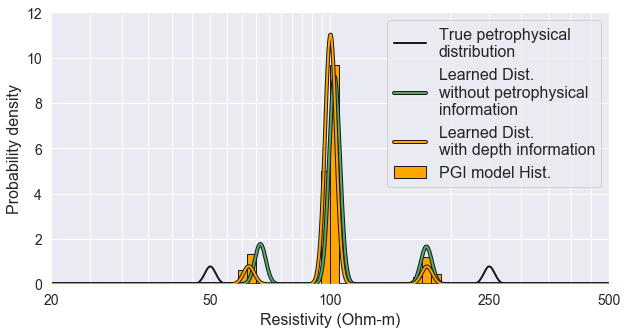

In [39]:
# Plot the recovered model histogram and learned petrophysical distribution from PGI without mean info 
# but with geological constraints.

clfrecoveredgeo = copy.deepcopy(invProb.reg.objfcts[0].GMmodel)
clfrecoveredgeo.weights_ = np.r_[0.875,0.063,0.062]
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(clf.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.plot(testXplot, np.exp(reg_nomean.GMmodel.score_samples(-np.log(testXplot))),
        linewidth=2,label='Learned Dist.\nwithout petrophysical\ninformation',c='g',
       path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
ax.plot(testXplot, np.exp(clfrecoveredgeo.score_samples(-np.log(testXplot))),
        linewidth=2,label='Learned Dist.\nwith depth information',c='orange',
       path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylabel('Probability density',fontsize=16)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="majorminor",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mcluster_nomean_borehole,bins=22, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='orange')
ax.legend(loc=0,fontsize=16)
ax.set_ylim([0.,12.])
plt.show()
#fig.savefig('DC2p5D_Hist_WithDepth_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0)
#fig.savefig('DC2p5D_Hist_WithDepth_LowRes.png', dpi=72, bbox_inches='tight', pad_inches=0)